In [20]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from tensorflow.keras.layers import Concatenate, Dense, Dropout, Input, IntegerLookup, Normalization, Reshape, StringLookup
from tensorflow.keras.models import Model

In [21]:
df_from_csv = pd.read_csv('data.csv',
                          chunksize=2048,
                          low_memory=False,
                          skiprows=lambda i: i > 0 and random.random() > 0.1)


In [22]:
x_encoder = OneHotEncoder(
    categories=[
        # age group
        ['0 - 17 years', '18 to 49 years', '50 to 64 years', '65+ years'],
        # exposure_yn
        ['Missing', 'Unknown', 'Yes'],
        # race
        [
            'American Indian/Alaska Native', 'Asian', 'Black',
            'Multiple/Other', 'Native Hawaiian/Other Pacific Islander', 'White'
        ],
        # sex
        ['Female', 'Male'],
        # state fips code
        [*range(1, 79)],
        # underlying_conditions_yn
        ['No', 'Yes'],
    ],
    handle_unknown='error',
)

y_encoder = OrdinalEncoder(
    categories=[
        ['No', 'Yes'],
    ],
    handle_unknown='error',
)


def open_csv_file(filename='data_train.csv', chunksize=2048):
    return pd.read_csv(filename,
                       chunksize=chunksize,
                       low_memory=False,
                       skiprows=lambda i: i > 0 and random.random() > 0.1)


def read_next_chunk(df):
    x = next(df)
    x.drop('Unnamed: 0', axis=1, inplace=True)

    y = x.pop('death_yn')

    x = x_encoder.fit_transform(x)
    y = y_encoder.fit_transform(y.values.reshape(-1, 1)).ravel()
    return (x, y)


n_encoded_features = read_next_chunk(open_csv_file(chunksize=16))[0].shape[1]

In [23]:
def build_model():
    x = input = Input(dtype='float32',
                      name='input',
                      shape=(n_encoded_features, ))

    x = Dense(32, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)

    output = Dense(1, activation='sigmoid', name='output')(x)

    model = Model(input, output)
    model.compile('adam', 'mean_squared_error', metrics=['accuracy'])

    return model


build_model().summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 95)]              0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                3072      
_________________________________________________________________
dense_15 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 4,161
Trainable params: 4,161
Non-trainable params: 0
_________________________________________________________________


In [24]:
def train():
    df = open_csv_file(chunksize=4096)
    model = build_model()

    try:
        while True:
            x, y = read_next_chunk(df)
            x, x_valid, y, y_valid = train_test_split(x, y, test_size=0.2)

            model.fit(
                x,
                y,
                callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=1),
                ],
                epochs=4,
                validation_data=(x_valid, y_valid),
            )
    except StopIteration:
        pass

    return model


trained_model = train()


Epoch 1/4


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_8/dense_16/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_8/dense_16/embedding_lookup_sparse/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradient_tape/model_8/dense_16/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
2021-12-06 21:58:40.711413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - 2s 13ms/step - loss: 0.1010 - accuracy: 0.8947 - val_loss: 0.0546 - val_accuracy: 0.9415
Epoch 2/4
  1/103 [..............................] - ETA: 1s - loss: 0.0370 - accuracy: 0.9688

2021-12-06 21:58:41.951709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - 1s 11ms/step - loss: 0.0427 - accuracy: 0.9576 - val_loss: 0.0547 - val_accuracy: 0.9415
Epoch 1/4
103/103 [==============================] - 1s 11ms/step - loss: 0.0499 - accuracy: 0.9463 - val_loss: 0.0383 - val_accuracy: 0.9537
Epoch 2/4
103/103 [==============================] - 1s 11ms/step - loss: 0.0425 - accuracy: 0.9478 - val_loss: 0.0320 - val_accuracy: 0.9561
Epoch 3/4
103/103 [==============================] - 1s 13ms/step - loss: 0.0367 - accuracy: 0.9554 - val_loss: 0.0308 - val_accuracy: 0.9634
Epoch 4/4
103/103 [==============================] - 1s 12ms/step - loss: 0.0343 - accuracy: 0.9582 - val_loss: 0.0299 - val_accuracy: 0.9634
Epoch 1/4
103/103 [==============================] - 1s 11ms/step - loss: 0.0326 - accuracy: 0.9625 - val_loss: 0.0378 - val_accuracy: 0.9500
Epoch 2/4
103/103 [==============================] - 1s 12ms/step - loss: 0.0315 - accuracy: 0.9640 - val_loss: 0.0371 - val_accuracy: 0.9500
Epoch 3/4
103/10

2021-12-06 21:59:55.750050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


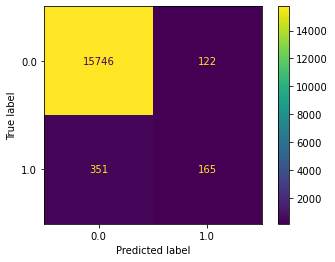

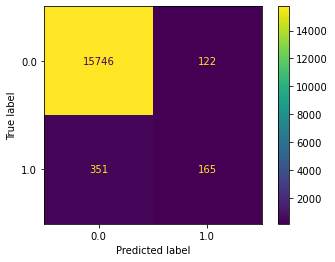

In [25]:
def benchmark(model):
    df = open_csv_file(filename='data_test.csv', chunksize=16384)
    x, y_true = read_next_chunk(df)

    y_pred = model.predict(x)
    y_pred = np.rint(y_pred)

    ConfusionMatrixDisplay.from_predictions(y_true, y_pred).plot()


benchmark(trained_model)